# Package & environment setup

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
import tensorflow as tf

print("TensorFlow version:", tf.__version__)
print("Available devices:", tf.config.list_physical_devices())
print("Is GPU available?", tf.test.is_gpu_available())


Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


TensorFlow version: 2.17.1
Available devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Is GPU available? True


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir('/content/drive/MyDrive/Colab Notebooks/nba_shot_prediction')

Mounted at /content/drive


In [ ]:
df = pd.DataFrame()
for file in os.listdir(("data")):
    temp = pd.read_csv(f"data/{file}")
    df = pd.concat([df, temp])

In [ ]:
df.columns

Index(['SEASON_1', 'SEASON_2', 'TEAM_ID', 'TEAM_NAME', 'PLAYER_ID',
       'PLAYER_NAME', 'POSITION_GROUP', 'POSITION', 'GAME_DATE', 'GAME_ID',
       'HOME_TEAM', 'AWAY_TEAM', 'EVENT_TYPE', 'SHOT_MADE', 'ACTION_TYPE',
       'SHOT_TYPE', 'BASIC_ZONE', 'ZONE_NAME', 'ZONE_ABB', 'ZONE_RANGE',
       'LOC_X', 'LOC_Y', 'SHOT_DISTANCE', 'QUARTER', 'MINS_LEFT', 'SECS_LEFT'],
      dtype='object')

# Feature processing

### Problem of 'Player name' feature
* Who is the player that made a shot, is very important feature.
* However, it is very difficult to put it as categorical values.

Now, let's think about, 'why' is the player name important.
When we see James Harden shoots 3 pointer, know that 'historically', since he made many 3 pointer shots, he is the one wh's good at shot. So, it's all about historical data of each player's shoot success.

So, I would like to

1. Make ave_soot_stat dictionary for all players.
2. Replace player's name with their ave shoot success rate.
3. When predicting, we can refer to the dictionary, to use that player's avg_shoot_stat.

In [ ]:
players = np.unique(df[["PLAYER_ID"]])
player_goal_stat = {}

for p in players:
    temp = df.loc[df["PLAYER_ID"] == p]["SHOT_MADE"]
    avg = round(sum(temp.values) / temp.shape[0], 2)
    player_goal_stat[p] = avg

In [ ]:
df["PLAYER_AVG_SHOT_RATE"] = df["PLAYER_ID"].apply(lambda x: player_goal_stat[x])

In [ ]:
df[["TEAM_ID", "TEAM_NAME", "PLAYER_ID", "PLAYER_NAME", "PLAYER_AVG_SHOT_RATE"]].head(
    10
)

,TEAM_ID,TEAM_NAME,PLAYER_ID,PLAYER_NAME,PLAYER_AVG_SHOT_RATE
0,1610612764,Washington Wizards,203078,Bradley Beal,0.47
1,1610612764,Washington Wizards,204001,Kristaps Porzingis,0.46
2,1610612764,Washington Wizards,1628420,Monte Morris,0.48
3,1610612764,Washington Wizards,204001,Kristaps Porzingis,0.46
4,1610612764,Washington Wizards,1630166,Deni Avdija,0.46
5,1610612764,Washington Wizards,204001,Kristaps Porzingis,0.46
6,1610612764,Washington Wizards,1628420,Monte Morris,0.48
7,1610612764,Washington Wizards,1628398,Kyle Kuzma,0.45
8,1610612764,Washington Wizards,1628398,Kyle Kuzma,0.45
9,1610612764,Washington Wizards,1628398,Kyle Kuzma,0.45


# Preprocessing features

Now, we should preprocess the features. Howeverm we will make some assumptions.

First, I will only predict shot success probability based on the conditions related to the games, and individual capability of the players.
Which means, I will not use 'TEAM' information. There are two reasons.

First, shot success rate prediction should be more focused on 'the moment'. For instance, GSW could have high 3 pt success rate because of Stephen Curry. This does not mean that any other players in GSW should have advantage when computing probability of shot success.

If we are using regression based model (e.g. Logistic regression), meaningful feaeture should add information helpful for prediction of the target. Here, we are asumming that knowing which team is the player in does not help predict his shot success rate.

Second, like player name encoding teams into categorical data will increase number of features to large extent, increasing complexity of the model.

In [ ]:
df.head()

,SEASON_1,SEASON_2,TEAM_ID,TEAM_NAME,PLAYER_ID,PLAYER_NAME,POSITION_GROUP,POSITION,GAME_DATE,GAME_ID,...,ZONE_NAME,ZONE_ABB,ZONE_RANGE,LOC_X,LOC_Y,SHOT_DISTANCE,QUARTER,MINS_LEFT,SECS_LEFT,PLAYER_AVG_SHOT_RATE
0,2023,2022-23,1610612764,Washington Wizards,203078,Bradley Beal,G,SG,10-19-2022,22200004,...,Left Side,L,24+ ft.,23.4,12.95,24,1,11,20,0.47
1,2023,2022-23,1610612764,Washington Wizards,204001,Kristaps Porzingis,C,C,10-19-2022,22200004,...,Center,C,24+ ft.,-0.4,31.45,26,1,10,52,0.46
2,2023,2022-23,1610612764,Washington Wizards,1628420,Monte Morris,G,PG,10-19-2022,22200004,...,Center,C,Less Than 8 ft.,-1.3,5.25,1,1,10,39,0.48
3,2023,2022-23,1610612764,Washington Wizards,204001,Kristaps Porzingis,C,C,10-19-2022,22200004,...,Center,C,Less Than 8 ft.,-0.1,7.25,2,1,10,31,0.46
4,2023,2022-23,1610612764,Washington Wizards,1630166,Deni Avdija,F,SF,10-19-2022,22200004,...,Center,C,Less Than 8 ft.,1.8,7.15,2,1,10,5,0.46


For HOME / AWAY, rather if the player was at home / away could be meaningful. Therefore, I will process the data to get 'if_player_home'


In [ ]:
df["TARGET"] = [1 if i == True else 0 for i in df.SHOT_MADE.values]

In [ ]:
nba_team_abbreviations = {
    "Atlanta Hawks": "ATL",
    "Boston Celtics": "BOS",
    "Brooklyn Nets": "BKN",
    "Charlotte Hornets": "CHA",
    "Chicago Bulls": "CHI",
    "Cleveland Cavaliers": "CLE",
    "Dallas Mavericks": "DAL",
    "Denver Nuggets": "DEN",
    "Detroit Pistons": "DET",
    "Golden State Warriors": "GSW",
    "Houston Rockets": "HOU",
    "Indiana Pacers": "IND",
    "Los Angeles Clippers": "LAC",
    "Los Angeles Lakers": "LAL",
    "Memphis Grizzlies": "MEM",
    "Miami Heat": "MIA",
    "Milwaukee Bucks": "MIL",
    "Minnesota Timberwolves": "MIN",
    "New Orleans Pelicans": "NOP",
    "New York Knicks": "NYK",
    "Oklahoma City Thunder": "OKC",
    "Orlando Magic": "ORL",
    "Philadelphia 76ers": "PHI",
    "Phoenix Suns": "PHX",
    "Portland Trail Blazers": "POR",
    "Sacramento Kings": "SAC",
    "San Antonio Spurs": "SAS",
    "Toronto Raptors": "TOR",
    "Utah Jazz": "UTA",
    "Washington Wizards": "WAS",
}

df["IS_PLAYER_HOME"] = df["TEAM_NAME"] == df["HOME_TEAM"]

In [ ]:
numerical = [
    "PLAYER_AVG_SHOT_RATE",
    "LOC_X",
    "LOC_Y",
    "SHOT_DISTANCE",
    "QUARTER",
    "MINS_LEFT",
    "SECS_LEFT",
]
categorical = [
    "SEASON_2",
    # "ZONE_ABB",
    # "ZONE_NAME",
    "ACTION_TYPE",
    "SHOT_TYPE",
    "BASIC_ZONE",
    # "POSITION_GROUP",
    "POSITION",
    "IS_PLAYER_HOME",
    "ZONE_RANGE",
]

In [ ]:
df[numerical].head()

,PLAYER_AVG_SHOT_RATE,LOC_X,LOC_Y,SHOT_DISTANCE,QUARTER,MINS_LEFT,SECS_LEFT
0,0.47,23.4,12.95,24,1,11,20
1,0.46,-0.4,31.45,26,1,10,52
2,0.48,-1.3,5.25,1,1,10,39
3,0.46,-0.1,7.25,2,1,10,31
4,0.46,1.8,7.15,2,1,10,5


In [ ]:
df[categorical].head()

,SEASON_2,ACTION_TYPE,SHOT_TYPE,BASIC_ZONE,POSITION,IS_PLAYER_HOME,ZONE_RANGE
0,2022-23,Jump Shot,3PT Field Goal,Left Corner 3,SG,False,24+ ft.
1,2022-23,Step Back Jump shot,3PT Field Goal,Above the Break 3,C,False,24+ ft.
2,2022-23,Running Finger Roll Layup Shot,2PT Field Goal,Restricted Area,PG,False,Less Than 8 ft.
3,2022-23,Cutting Dunk Shot,2PT Field Goal,Restricted Area,C,False,Less Than 8 ft.
4,2022-23,Cutting Dunk Shot,2PT Field Goal,Restricted Area,SF,False,Less Than 8 ft.


In [ ]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
encoder = OneHotEncoder(sparse_output=False)

# Scaling
numerical_scaled = scaler.fit_transform(df[numerical])
numerical_scaled = pd.DataFrame(numerical_scaled, columns=df[numerical].columns)


# ONE-HOT Encoding
categorical_encoded = encoder.fit_transform(df[categorical])
categorical_encoded = pd.DataFrame(
    categorical_encoded, columns=encoder.get_feature_names_out()
)

In [ ]:
X_transformed = pd.concat([numerical_scaled, categorical_encoded], axis=1)
y = df["TARGET"]

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X_transformed, y, test_size=0.3, random_state=20
)

# Logistic Regression - plain model without parameter tuning

In [ ]:
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

classifier = LogisticRegression()
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_val)
y_prob = classifier.predict_proba(X_val)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
accuracy = accuracy_score(y_val.values, y_pred)
precision = precision_score(y_val, y_pred)
recall = recall_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")

Accuracy: 0.6304666679448588
Precision: 0.66415807044092
Recall: 0.3990955440098012
F1-Score: 0.4985875859317922


Logistic Regression:


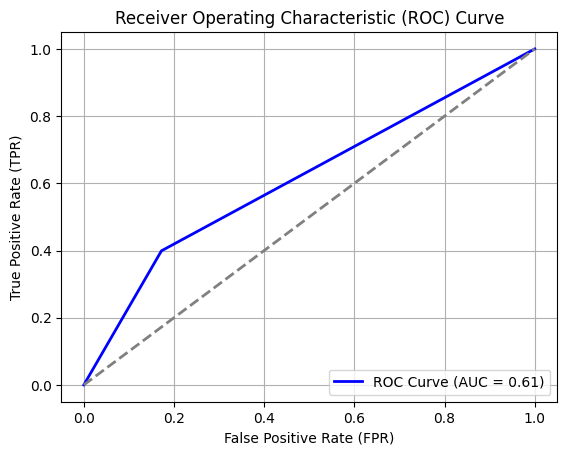

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt


def plot_roc_curve(model, X_val, y_val):
    y_pred_prob = model.predict(X_val)
    fpr, tpr, thresholds = roc_curve(y_val, y_pred_prob)

    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color="blue", lw=2, label=f"ROC Curve (AUC = {roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], color="gray", linestyle="--", lw=2)  # Diagonal line
    plt.xlabel("False Positive Rate (FPR)")
    plt.ylabel("True Positive Rate (TPR)")
    plt.title("Receiver Operating Characteristic (ROC) Curve")
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()


print("Logistic Regression:")
plot_roc_curve(classifier, X_val, y_val)

Accuracy is not that high, and recall score is low.

Let's plot how does default threshold 0.5 classifies the data:

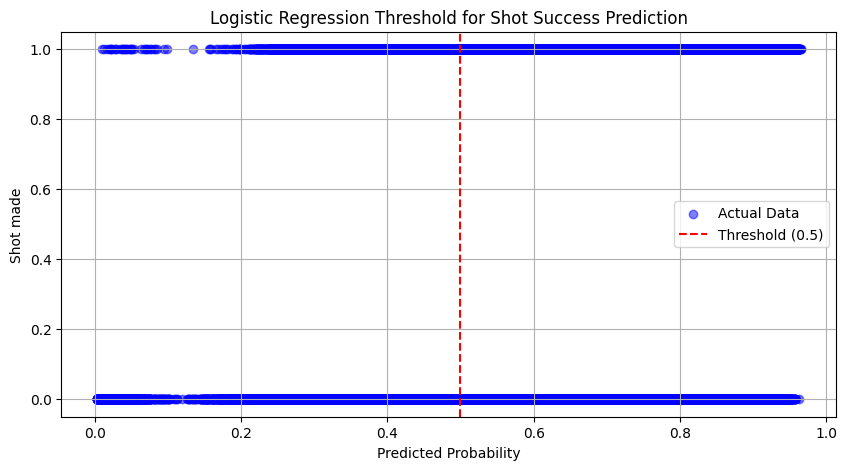

In [ ]:
import numpy as np

probabilities = y_prob[:, 1]
plt.figure(figsize=(10, 5))
plt.scatter(probabilities, y_val, alpha=0.5, label="Actual Data", color="blue")

plt.axvline(
    x=0.5, color="red", linestyle="--", label="Threshold (0.5)"
)  # Threshold line

plt.title("Logistic Regression Threshold for Shot Success Prediction")
plt.xlabel("Predicted Probability")
plt.ylabel("Shot made")
plt.legend()
plt.grid(True)
plt.show()

<ipython-input-22-0d3ac31919ed>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


<Axes: xlabel='y_val', ylabel='y_prob'>

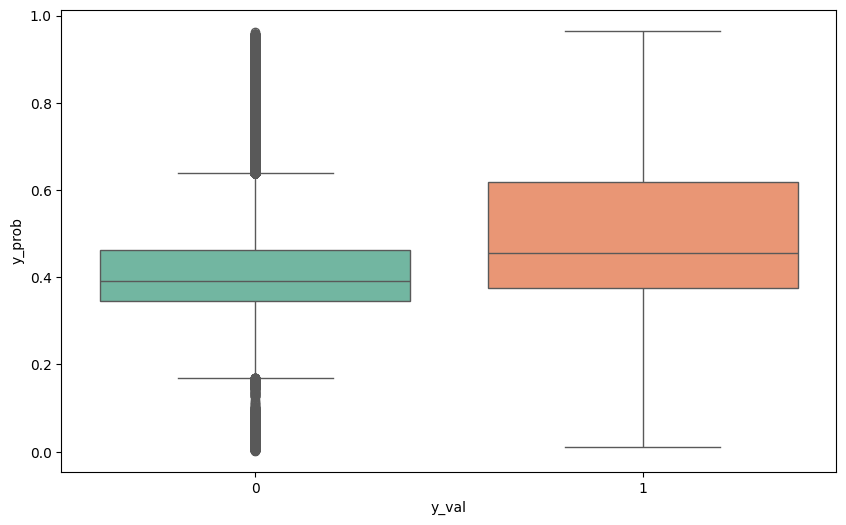

In [ ]:
import seaborn as sns

classification_data = pd.DataFrame({"y_val": y_val, "y_prob": y_prob[:, 1]})

plt.figure(figsize=(10, 6))
sns.boxplot(
    x="y_val",
    y="y_prob",
    data=classification_data,
    palette="Set2",
)

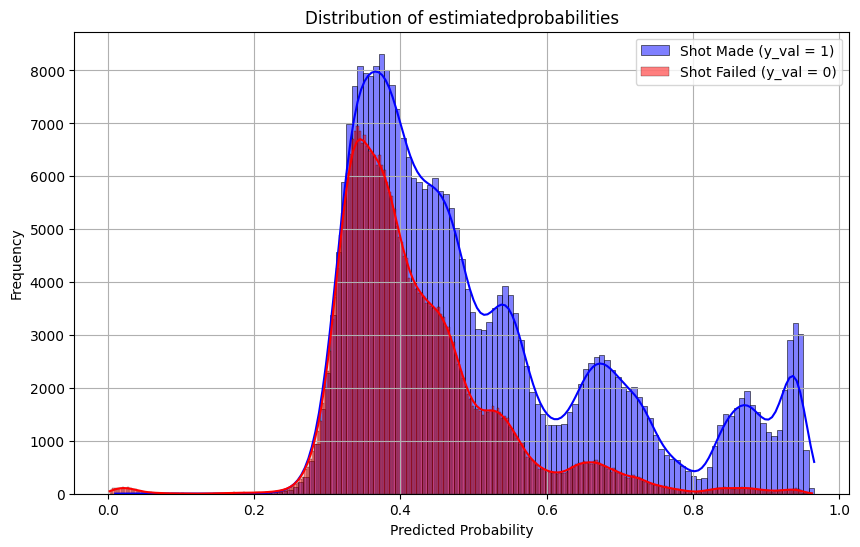

In [ ]:
# Let's see distribution of probabilities

shot_made = classification_data.loc[classification_data.y_val == 1]
shot_failed = classification_data.loc[classification_data.y_val == 0]

plt.figure(figsize=(10, 6))

sns.histplot(
    shot_made["y_prob"],
    label="Shot Made (y_val = 1)",
    kde=True,
    color="blue",
    alpha=0.5,
)
sns.histplot(
    shot_failed["y_prob"],
    label="Shot Failed (y_val = 0)",
    kde=True,
    color="red",
    alpha=0.5,
)

plt.title("Distribution of estimiatedprobabilities")
plt.xlabel("Predicted Probability")
plt.legend()
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

# Parameter optimization with GridCV - Optional

For this project, I will predict 'probability', so optimizing for thredhold is not necessary. However, if you would like to optimize threshold, we can define custim class of logistic regression that takes threshold as custome parameter.


The Logistic Regression from sklearn does not have 'threshold' as a native parameter. Therefore, we can define a custom class 'LogisticRegressionTrheshold which takes threshold as a parameter, predict classes based on the threshold.

In [ ]:
from sklearn.model_selection import GridSearchCV

logistic_regression = LogisticRegression(
    penalty="l1", C=0.001, solver="liblinear"
)  # Native Parameters


def threshold_score(estimator, X, y, threshold=0.5):
    prob = estimator.predict_proba(X)[:, 1]
    y_pred = (prob > threshold).astype(int)
    return accuracy_score(y, y_pred)


class LogisticRegressionTrheshold:
    def __init__(self, model, threshold=0.5):
        self.model = model
        self.threshold = threshold

    def fit(self, X, y):
        self.model.fit(X, y)
        return self

    def predict(self, X):
        prob = self.model.predict_proba(X)[:, 1]
        y_pred = (prob > self.threshold).astype(int)
        return y_pred

    def predict_proba(self, X):
        return self.model.predict_proba(X)

    def get_params(self, deep=True):
        return {"model": self.model, "threshold": self.threshold}

    def set_params(self, **params):
        for param, value in params.items():
            setattr(self, param, value)
        return self


lr_with_threshold = LogisticRegressionTrheshold(logistic_regression, threshold=0.5)

parameters = {
    "model__C": [
        0.001,
        0.01,
        0.1,
        1,
        10,
        100,
    ],  # native parameter - Regularization Parameter
    "model__penalty": ["l1", "l2"],  # native parameter
    "threshold": [0.3, 0.4, 0.5, 0.6, 0.7],
}

grid_search = GridSearchCV(
    estimator=lr_with_threshold,
    param_grid=parameters,
    cv=5,
    scoring=threshold_score,
    verbose=2,
)

# grid_search.fit(X_train, y_train)


# lr_best_model = grid_search.best_estimator_
# lr_best_params = grid_search.best_params_
# lr_best_score = grid_search.best_score_

# Based on Parameter Tuning
# print(f"Best Model: {lr_best_model}")
# print(f"Best Parameters: {lr_best_params}")
# print(f"Best Score: {lr_best_score}")

# lr_best_model.fit(X_train, y_train)
# y_pred = lr_best_model.predict(X_val)
# y_prob = lr_best_model.predict_proba(X_val)

# accuracy = accuracy_score(y_val.values, y_pred)
# precision = precision_score(y_val, y_pred)
# recall = recall_score(y_val, y_pred)
# f1 = f1_score(y_val, y_pred)

# print(f"Accuracy: {accuracy}")
# print(f"Precision: {precision}")
# print(f"Recall: {recall}")
# print(f"F1-Score: {f1}")

In [ ]:
logistic_regression.fit(X_train, y_train)
y_pred = logistic_regression.predict(X_val)
y_prob = logistic_regression.predict_proba(X_val)

accuracy = accuracy_score(y_val.values, y_pred)
precision = precision_score(y_val, y_pred)
recall = recall_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")

Accuracy: 0.6261879198062261
Precision: 0.6524771985136809
Recall: 0.4022260862322085
F1-Score: 0.4976629042681788


Logistic Regression:


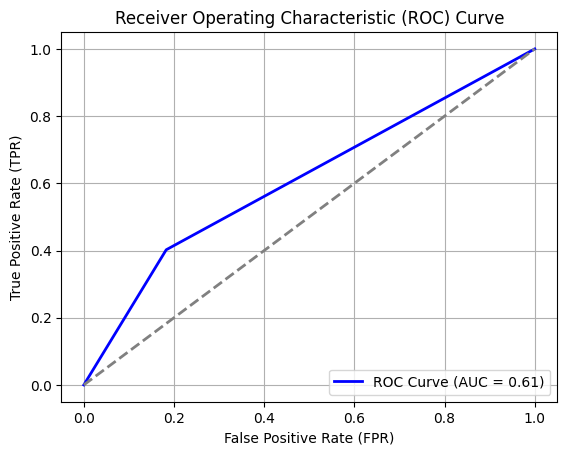

In [ ]:
print("Logistic Regression:")
plot_roc_curve(logistic_regression, X_val, y_val)

For this project, I'd only optimized C (regularization parameter)

# How to improve the model?

Let's see the plot once again. It is true that it's not realistic to predict every shots quite precisely. While watching NBA games, even prediction provided by the ClipperVision service shows missing predictions quite frequently.

I believe this is because the prediction only tells about 'how tough is each of the shot in general' - so rather than precisely predicting result of each shot, I think it's more important to give insight of how is each of the shots were 'tough shot' - so audiences could more interactively react to each of player's move.

For instance, it could be a more of 'wow' moment for Clippers fan if James Harden makes tough deep-three pointer shot, which is marked as 23%, rather than when he makes easy open lay-up shot that has been marked as 95%.

However, still, I believe there are still more rooms for effort for improvement. Let's look at the plots again.

<ipython-input-27-097257d85aca>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


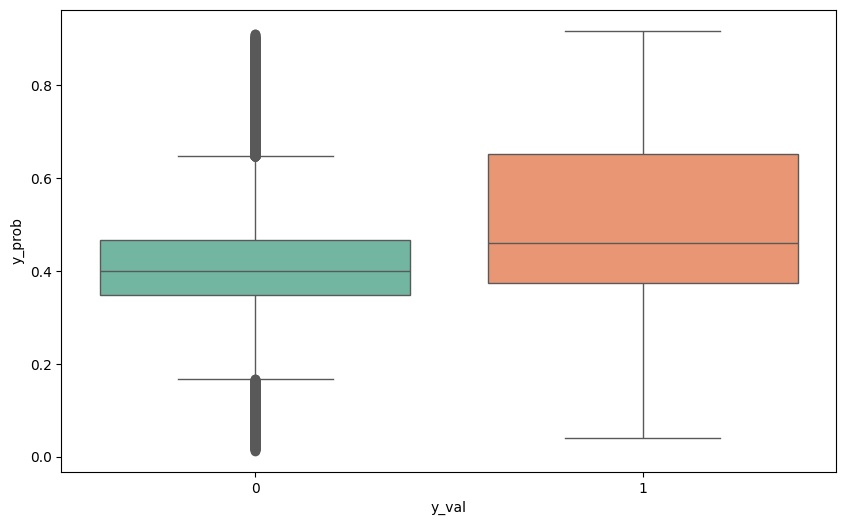

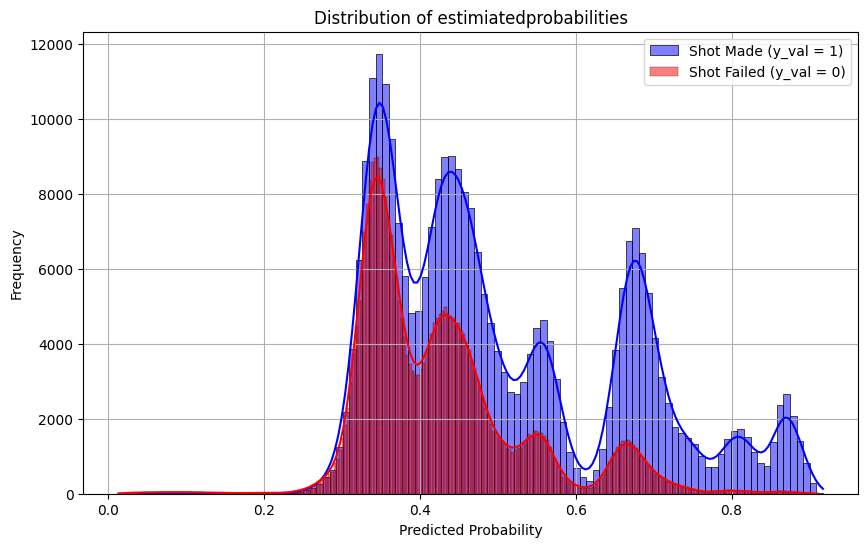

In [ ]:
import seaborn as sns

classification_data = pd.DataFrame({"y_val": y_val, "y_prob": y_prob[:, 1]})

plt.figure(figsize=(10, 6))
sns.boxplot(
    x="y_val",
    y="y_prob",
    data=classification_data,
    palette="Set2",
)

# Let's see distribution of probabilities

shot_made = classification_data.loc[classification_data.y_val == 1]
shot_failed = classification_data.loc[classification_data.y_val == 0]

plt.figure(figsize=(10, 6))

sns.histplot(
    shot_made["y_prob"],
    label="Shot Made (y_val = 1)",
    kde=True,
    color="blue",
    alpha=0.5,
)
sns.histplot(
    shot_failed["y_prob"],
    label="Shot Failed (y_val = 0)",
    kde=True,
    color="red",
    alpha=0.5,
)

plt.title("Distribution of estimiatedprobabilities")
plt.xlabel("Predicted Probability")
plt.legend()
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

We can see that the robabilities for 'successful' shots tend to be more higher, which is prospective. There are many shot attemps which were predicted to have lower hance under 0.4, but I believe this is okay - because NBA stars make many 'incredible' tough shots, and that's one of the most exciting moments of the league.

Also, we can rarely see failed shots markes with high probability - most of the attempts with probability higher than 0.7 succeeded.

The room for improvement exists around 0.3~0.4 probability. It would be much better, if we could get lower probability for failed shots.

I'll try to go through ANOVA - maybe some of features are making the model more complex, while being less significant.

# ANOVA for LR - Using R

In [ ]:
df.to_csv("aggregated_data_for_R.csv")

In [ ]:
'''# Generate data files for inclusion / Exclusion test

pd.concat(
    [df[numerical].reset_index(drop=True), y.reset_index(drop=True)], axis=1
).to_csv("numerical_only.csv", index=False)

for c in categorical:
    c_encoded = encoder.fit_transform(df[[c]])
    c_encoded = pd.DataFrame(c_encoded, columns=encoder.get_feature_names_out())
    pd.concat(
        [
            df[numerical].reset_index(drop=True),
            c_encoded.reset_index(drop=True),
            y.reset_index(drop=True),
        ],
        axis=1,
    ).to_csv(f"adding_{c}.csv", index=False)
files = [f"adding_{c}.csv" for c in categorical]
print(files)'''

'# Generate data files for inclusion / Exclusion test\n\npd.concat(\n    [df[numerical].reset_index(drop=True), y.reset_index(drop=True)], axis=1\n).to_csv("numerical_only.csv", index=False)\n\nfor c in categorical:\n    c_encoded = encoder.fit_transform(df[[c]])\n    c_encoded = pd.DataFrame(c_encoded, columns=encoder.get_feature_names_out())\n    pd.concat(\n        [\n            df[numerical].reset_index(drop=True),\n            c_encoded.reset_index(drop=True),\n            y.reset_index(drop=True),\n        ],\n        axis=1,\n    ).to_csv(f"adding_{c}.csv", index=False)\nfiles = [f"adding_{c}.csv" for c in categorical]\nprint(files)'

Conclusion from ANOVA
1. Deviance and AIC are quite high for the model. This could mean model itself have some dificulty explaining the data (in terms of fit), but it does not necessarily means the model is 'bad'. Low explanation of the data (in terms of fit) is explanable, because unlike other classification problems, each 'shots' made by NBA players have huge variance, and lot's of variables.

2. Does including all the categorical variables not helping? -> No. All of the categorical variables gisnificantly lowered deviacne, when conducting chi-square inclusion - exclusion test. Which means, including all categorical features can help getting better explanable 'probability' prediction model.

### R Script for ANOVA
```r
library(ggplot2)

data <- read.csv("aggregated_data_for_R_processed.csv")

out <- glm(TARGET ~ ., data = data, family = binomial(link = "logit"))
summary(out)

###Only numerical data
data <- read.csv("numerical_only.csv")
out_numerical <- glm(TARGET ~ ., data = data, family = binomial(link = "logit"))
summary(out_numerical)

### Comparing full and numerical model
delta_df <- out_numerical$df.resid - out$df.resid
delta_dev <- out_numerical$dev - out$dev

print('P-value:')
1-pchisq(delta_dev, df = delta_df)
# Null hypothesis: categorical variable coefficients are zero.
# Reject null : Deviance is not zero. Significant difference in deviance. Full model deviance is lower.

#Adding categorical data 1 by 1
data <- read.csv("adding_SEASON_2.csv")
out_adding_SEASON_2<- glm(TARGET ~ ., data = data, family = binomial(link = "logit"))
summary(out_adding_SEASON_2)

delta_df <- out_numerical$df.resid - out_adding_SEASON_2$df.resid
delta_dev <- out_numerical$dev - out_adding_SEASON_2$dev

print('P-value:')
1-pchisq(delta_dev, df = delta_df)
# We need to include season variable

data <- read.csv("adding_ZONE_ABB.csv")
out_adding_ZONE_ABB<- glm(TARGET ~ ., data = data, family = binomial(link = "logit"))
summary(out_adding_ZONE_ABB)

delta_df <- out_numerical$df.resid - out_adding_ZONE_ABB$df.resid
delta_dev <- out_numerical$dev - out_adding_ZONE_ABB$dev

print('P-value:')
1-pchisq(delta_dev, df = delta_df)

# >> Include Zone ABB

data <- read.csv("adding_ACTION_TYPE.csv")
adding_ACTION_TYPE<- glm(TARGET ~ ., data = data, family = binomial(link = "logit"))
summary(adding_ACTION_TYPE)

delta_df <- out_numerical$df.resid - adding_ACTION_TYPE$df.resid
delta_dev <- out_numerical$dev - adding_ACTION_TYPE$dev

print('P-value:')
1-pchisq(delta_dev, df = delta_df)
# >> Include

data <- read.csv("adding_SHOT_TYPE.csv")
adding_SHOT_TYPE<- glm(TARGET ~ ., data = data, family = binomial(link = "logit"))
summary(adding_SHOT_TYPE)

delta_df <- out_numerical$df.resid - adding_SHOT_TYPE$df.resid
delta_dev <- out_numerical$dev - adding_SHOT_TYPE$dev

print('P-value:')
1-pchisq(delta_dev, df = delta_df)
# >> Include

data <- read.csv("adding_BASIC_ZONE.csv")
adding_BASIC_ZONE<- glm(TARGET ~ ., data = data, family = binomial(link = "logit"))
summary(adding_BASIC_ZONE)

delta_df <- out_numerical$df.resid - adding_BASIC_ZONE$df.resid
delta_dev <- out_numerical$dev - adding_BASIC_ZONE$dev

print('P-value:')
1-pchisq(delta_dev, df = delta_df)

###

data <- read.csv("adding_POSITION.csv")
adding_POSITION<- glm(TARGET ~ ., data = data, family = binomial(link = "logit"))
summary(adding_POSITION)

delta_df <- out_numerical$df.resid - adding_POSITION$df.resid
delta_dev <- out_numerical$dev - adding_POSITION$dev

print('P-value:')
1-pchisq(delta_dev, df = delta_df)

###
data <- read.csv("adding_IS_PLAYER_HOME.csv")
adding_IS_PLAYER_HOME<- glm(TARGET ~ ., data = data, family = binomial(link = "logit"))
summary(adding_IS_PLAYER_HOME)

delta_df <- out_numerical$df.resid - adding_IS_PLAYER_HOME$df.resid
delta_dev <- out_numerical$dev - adding_IS_PLAYER_HOME$dev

print('P-value:')
1-pchisq(delta_dev, df = delta_df)

###
data <- read.csv("adding_ZONE_RANGE.csv")
adding_ZONE_RANGE<- glm(TARGET ~ ., data = data, family = binomial(link = "logit"))
summary(adding_ZONE_RANGE)

delta_df <- out_numerical$df.resid - adding_ZONE_RANGE$df.resid
delta_dev <- out_numerical$dev - adding_ZONE_RANGE$dev

print('P-value:')
1-pchisq(delta_dev, df = delta_df)




So, maybe because of variability of the 'shot success' rate, there could be limitations building proabability model with logistic regression.

The, what if we try tree based models, and neural network for the classification?

This might be limitation of 'nonlinearity', because logistic regression basically captures linear relationship.

# XGBoost - Plain model without feature engineering

In [ ]:
from xgboost import XGBClassifier
X_train, X_val, y_train, y_val = train_test_split(
    X_transformed, y, test_size=0.3, random_state=20
)

XGB = XGBClassifier(objective="binary:logistic")
XGB.fit(X_train, y_train)


y_pred = XGB.predict(X_val)
y_prob = XGB.predict_proba(X_val)[:, 1]

In [ ]:
accuracy = accuracy_score(y_val.values, y_pred)
precision = precision_score(y_val, y_pred)
recall = recall_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")

Accuracy: 0.6416987812438087
Precision: 0.6812460274221375
Recall: 0.41662241565409935
F1-Score: 0.5170425789889671


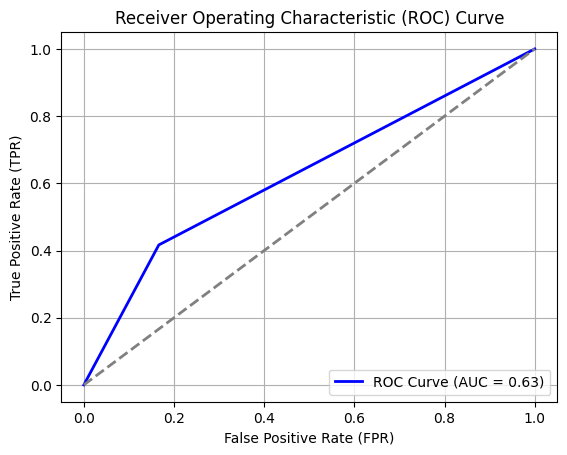

In [ ]:
plot_roc_curve(XGB, X_val, y_val)

<ipython-input-33-4fbd7a4455d0>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


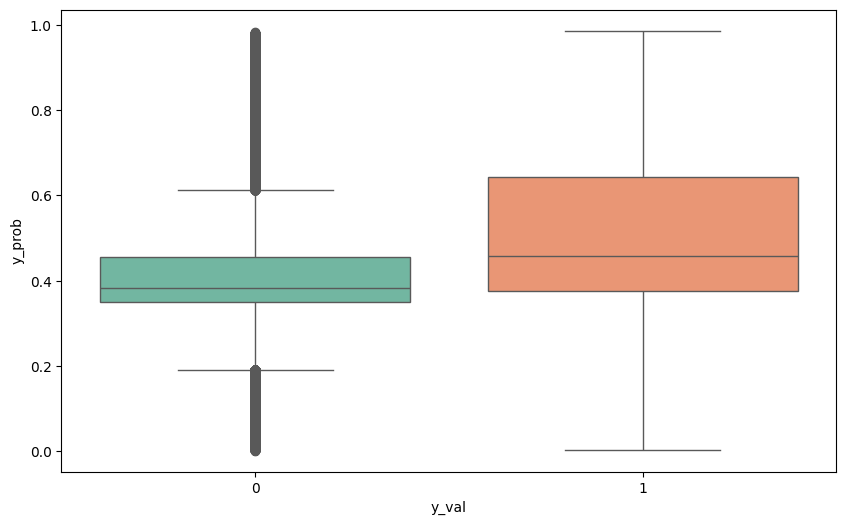

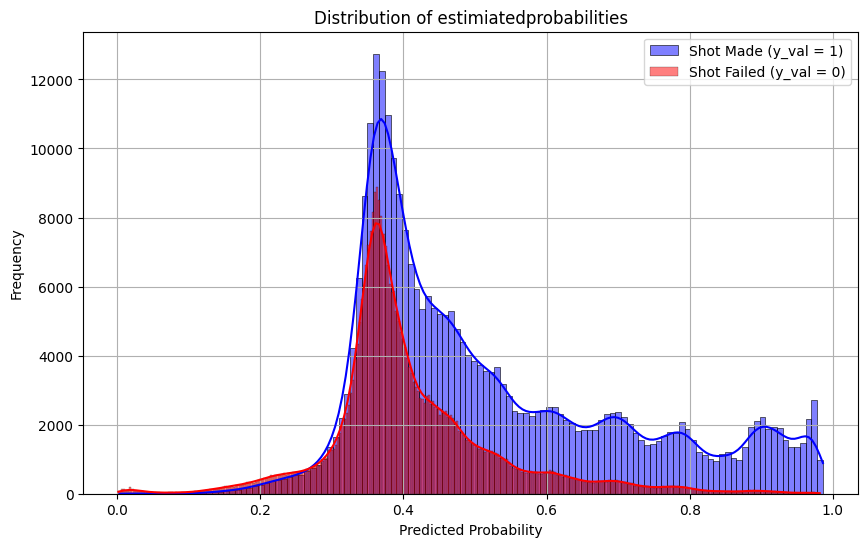

In [ ]:
classification_data = pd.DataFrame({"y_val": y_val.values, "y_prob": y_prob})

plt.figure(figsize=(10, 6))
sns.boxplot(
    x="y_val",
    y="y_prob",
    data=classification_data,
    palette="Set2",
)

# Let's see distribution of probabilities

shot_made = classification_data.loc[classification_data.y_val == 1]
shot_failed = classification_data.loc[classification_data.y_val == 0]

plt.figure(figsize=(10, 6))

sns.histplot(
    shot_made["y_prob"],
    label="Shot Made (y_val = 1)",
    kde=True,
    color="blue",
    alpha=0.5,
)
sns.histplot(
    shot_failed["y_prob"],
    label="Shot Failed (y_val = 0)",
    kde=True,
    color="red",
    alpha=0.5,
)

plt.title("Distribution of estimiatedprobabilities")
plt.xlabel("Predicted Probability")
plt.legend()
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

# How can we distinguish 'tough' shots? 0.3~0.4 probability shots that had been made?

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(
    X_transformed, y, test_size=0.3, random_state=20
)

In [ ]:
total = pd.concat([X_val.reset_index(drop = True), y_val.reset_index(drop = True)], axis=1)
total["prediction"] = y_prob

In [ ]:
def categorize_prediction(pred):
    if pred < 0.3:
        return "Very Low (<0.3)"
    elif 0.3 <= pred < 0.5:
        return "Low (0.3-0.5)"
    elif 0.5 <= pred < 0.7:
        return "High (0.5-0.7)"
    else:  # pred >= 0.7
        return "Very High (>=0.7)"


total["pred_range"] = total["prediction"].apply(lambda x: categorize_prediction(x))

<Axes: xlabel='pred_range', ylabel='PLAYER_AVG_SHOT_RATE'>

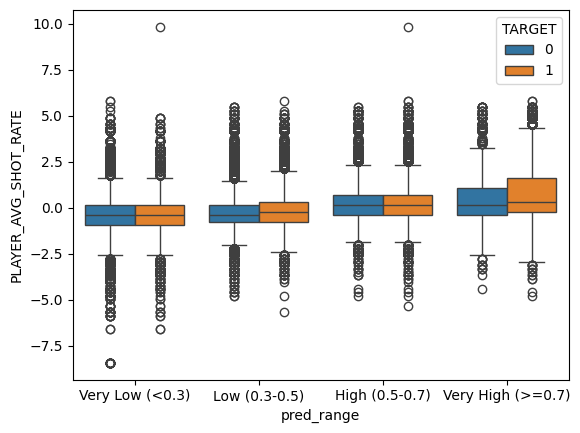

In [ ]:
pred_range_order = [
    "Very Low (<0.3)",
    "Low (0.3-0.5)",
    "High (0.5-0.7)",
    "Very High (>=0.7)",
]

sns.boxplot(
    data=total,
    x="pred_range",
    y="PLAYER_AVG_SHOT_RATE",
    hue="TARGET",
    order=pred_range_order,
)

<Axes: xlabel='pred_range', ylabel='SHOT_DISTANCE'>

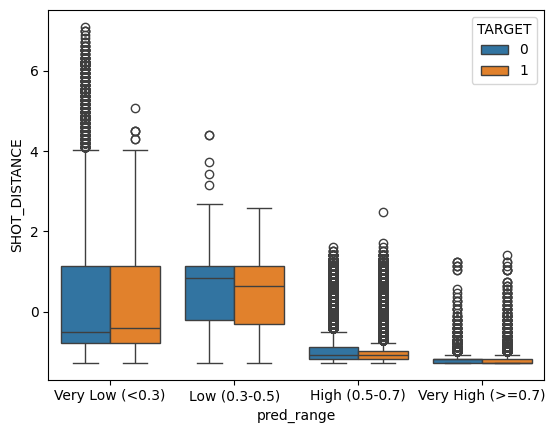

In [ ]:
sns.boxplot(
    data=total,
    x="pred_range",
    y="SHOT_DISTANCE",
    hue="TARGET",
    order=pred_range_order,
)

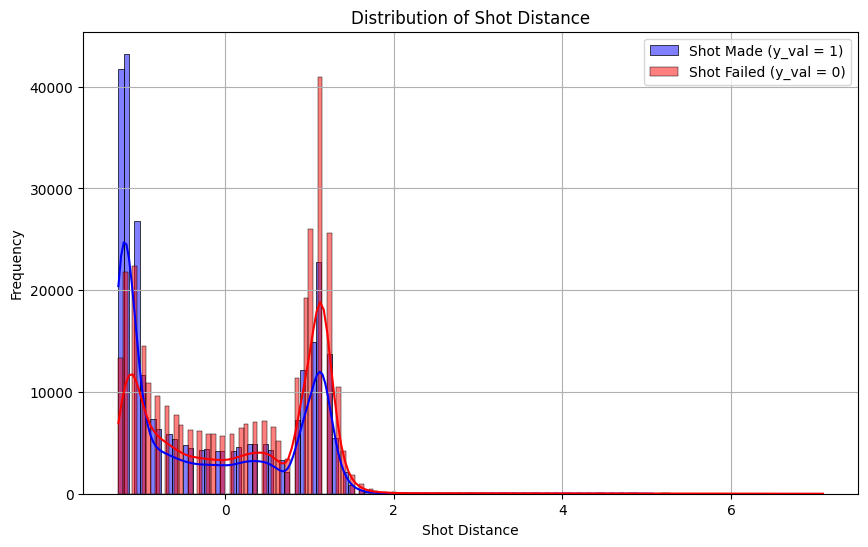

In [ ]:
plt.figure(figsize=(10, 6))

shot_made

sns.histplot(
    total[total["TARGET"] == 1]["SHOT_DISTANCE"],
    label="Shot Made (y_val = 1)",
    kde=True,
    color="blue",
    alpha=0.5,
)
sns.histplot(
    total[total["TARGET"] == 0]["SHOT_DISTANCE"],
    label="Shot Failed (y_val = 0)",
    kde=True,
    color="red",
    alpha=0.5,
)

plt.title("Distribution of Shot Distance")
plt.xlabel("Shot Distance")
plt.legend()
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

* Hypothesis: 3 Pointer shots



Text(0, 0.5, 'Prediction')

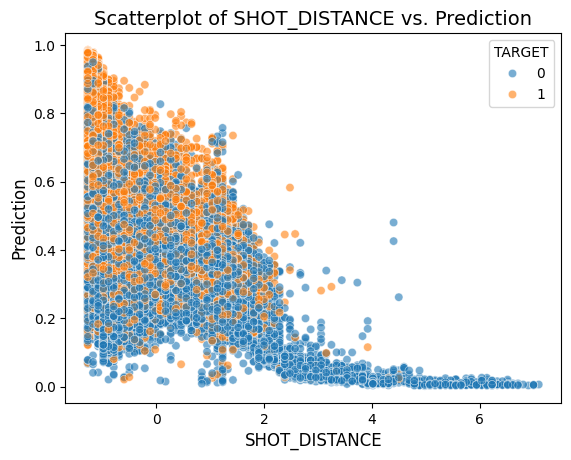

In [ ]:
sns.scatterplot(
    data=total,
    x="SHOT_DISTANCE",
    y="prediction",
    hue="TARGET",  # Optional: Use color to differentiate TARGET values
    alpha=0.6,  # Optional: Adjust transparency for overlapping points
)

plt.title("Scatterplot of SHOT_DISTANCE vs. Prediction", fontsize=14)
plt.xlabel("SHOT_DISTANCE", fontsize=12)
plt.ylabel("Prediction", fontsize=12)

Text(0, 0.5, 'Prediction')

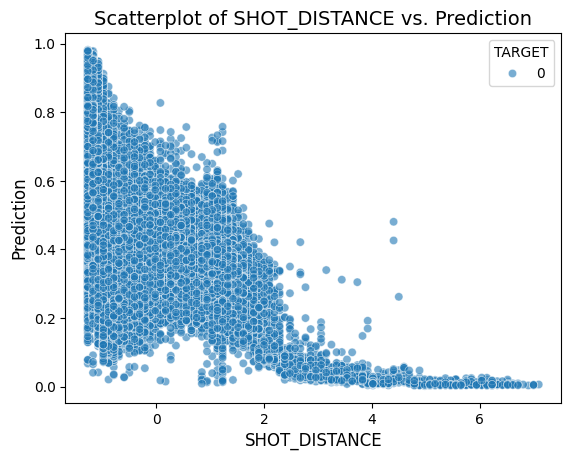

In [ ]:
sns.scatterplot(
    data=total[total["TARGET"] == 0],
    x="SHOT_DISTANCE",
    y="prediction",
    hue="TARGET",  # Optional: Use color to differentiate TARGET values
    alpha=0.6,  # Optional: Adjust transparency for overlapping points
)

plt.title("Scatterplot of SHOT_DISTANCE vs. Prediction", fontsize=14)
plt.xlabel("SHOT_DISTANCE", fontsize=12)
plt.ylabel("Prediction", fontsize=12)

Text(0, 0.5, 'Prediction')

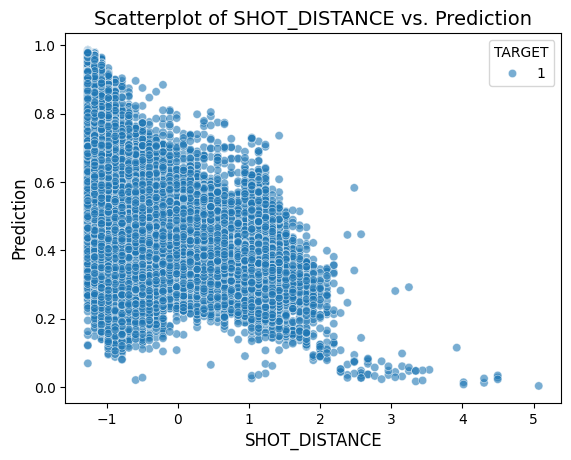

In [ ]:
sns.scatterplot(
    data=total[total["TARGET"] == 1],
    x="SHOT_DISTANCE",
    y="prediction",
    hue="TARGET",  # Optional: Use color to differentiate TARGET values
    alpha=0.6,  # Optional: Adjust transparency for overlapping points
)

plt.title("Scatterplot of SHOT_DISTANCE vs. Prediction", fontsize=14)
plt.xlabel("SHOT_DISTANCE", fontsize=12)
plt.ylabel("Prediction", fontsize=12)

<ipython-input-43-380fc890e89c>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
<ipython-input-43-380fc890e89c>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


Text(0.5, 1.0, 'Two point shots')

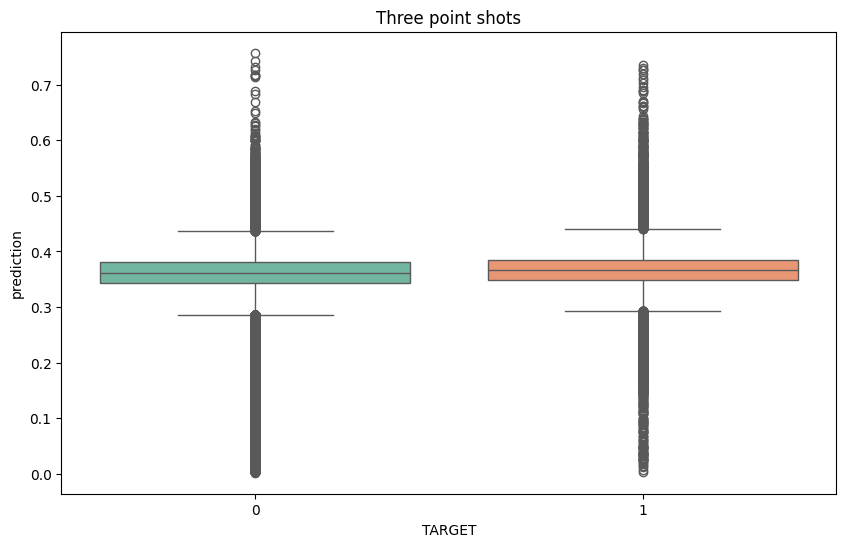

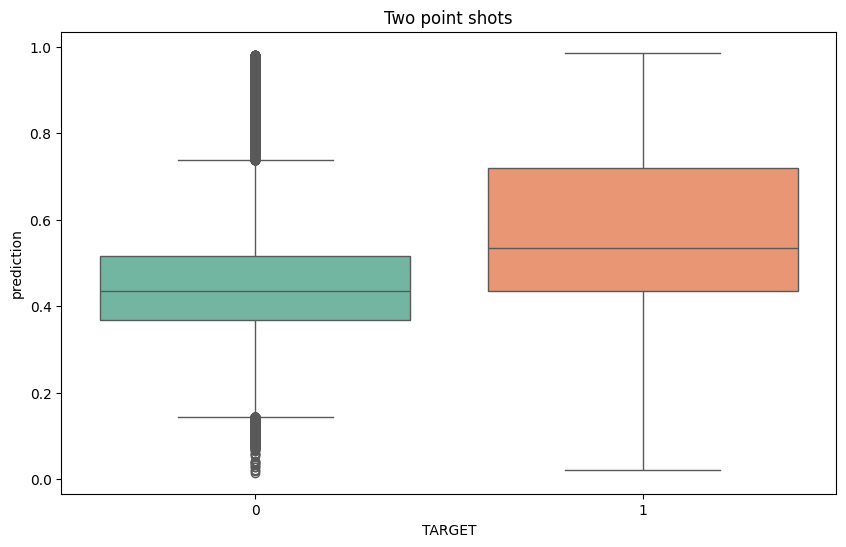

In [ ]:
threes = total[total["SHOT_TYPE_3PT Field Goal"] == 1]
twos = total[total["SHOT_TYPE_3PT Field Goal"] == 0]

plt.figure(figsize=(10, 6))
sns.boxplot(
    x="TARGET",
    y="prediction",
    data=threes,
    palette="Set2",
)
plt.title("Three point shots")

plt.figure(figsize=(10, 6))
sns.boxplot(
    x="TARGET",
    y="prediction",
    data=twos,
    palette="Set2",
)

plt.title("Two point shots")

# 3 Point shots - Adding interaction term

In [ ]:
X_transformed["interaction_term"] = (
    X_transformed["SHOT_TYPE_3PT Field Goal"] * X_transformed["SHOT_DISTANCE"]
)

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(
    X_transformed, y, test_size=0.3, random_state=20
)

In [ ]:
logistic_regression = LogisticRegression(
    penalty="l1", C=0.001, solver="liblinear"
)  # Native Parameters


logistic_regression.fit(X_train, y_train)
y_pred = logistic_regression.predict(X_val)
y_prob = logistic_regression.predict_proba(X_val)[:, 1]

accuracy = accuracy_score(y_val.values, y_pred)
precision = precision_score(y_val, y_pred)
recall = recall_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")

Accuracy: 0.6261719424046629
Precision: 0.652490257473025
Recall: 0.40212543687029073
F1-Score: 0.4975896551650093


Logistic Regression:


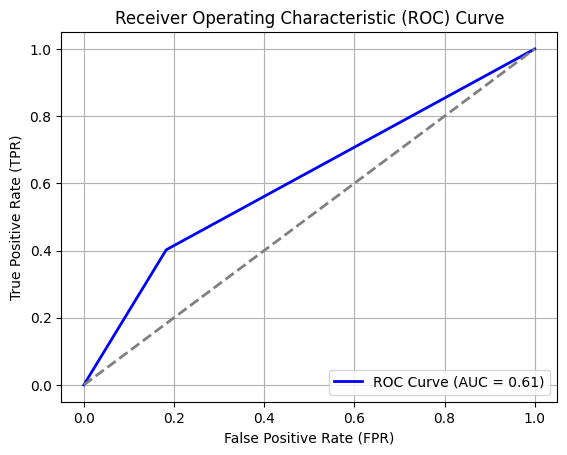

In [ ]:
print("Logistic Regression:")
plot_roc_curve(logistic_regression, X_val, y_val)

<ipython-input-48-4fbd7a4455d0>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


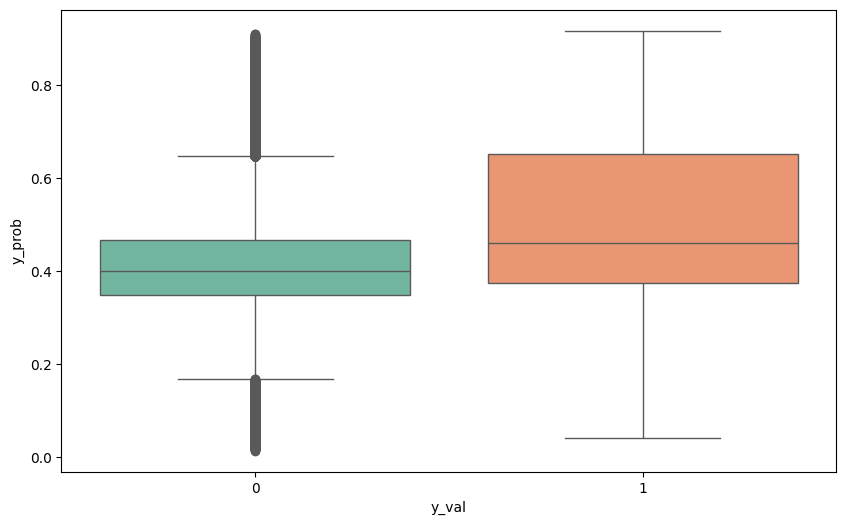

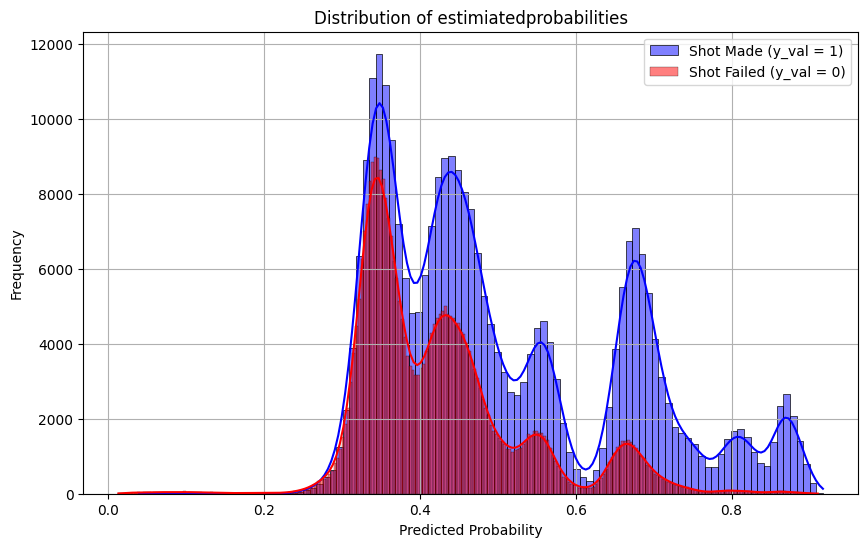

In [ ]:
classification_data = pd.DataFrame({"y_val": y_val.values, "y_prob": y_prob})

plt.figure(figsize=(10, 6))
sns.boxplot(
    x="y_val",
    y="y_prob",
    data=classification_data,
    palette="Set2",
)

# Let's see distribution of probabilities

shot_made = classification_data.loc[classification_data.y_val == 1]
shot_failed = classification_data.loc[classification_data.y_val == 0]

plt.figure(figsize=(10, 6))

sns.histplot(
    shot_made["y_prob"],
    label="Shot Made (y_val = 1)",
    kde=True,
    color="blue",
    alpha=0.5,
)
sns.histplot(
    shot_failed["y_prob"],
    label="Shot Failed (y_val = 0)",
    kde=True,
    color="red",
    alpha=0.5,
)

plt.title("Distribution of estimiatedprobabilities")
plt.xlabel("Predicted Probability")
plt.legend()
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

Accuracy: 0.6418106230547513
Precision: 0.6807798434884879
Recall: 0.4178683853412881
F1-Score: 0.5178661677258406


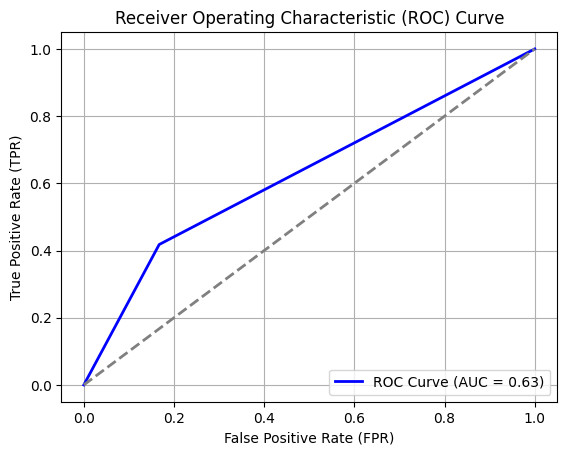

<ipython-input-49-a959bd6390ee>:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


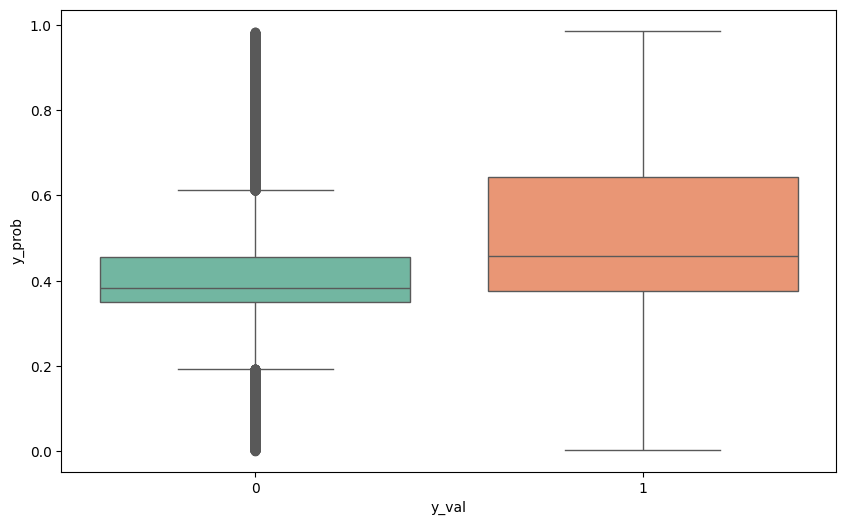

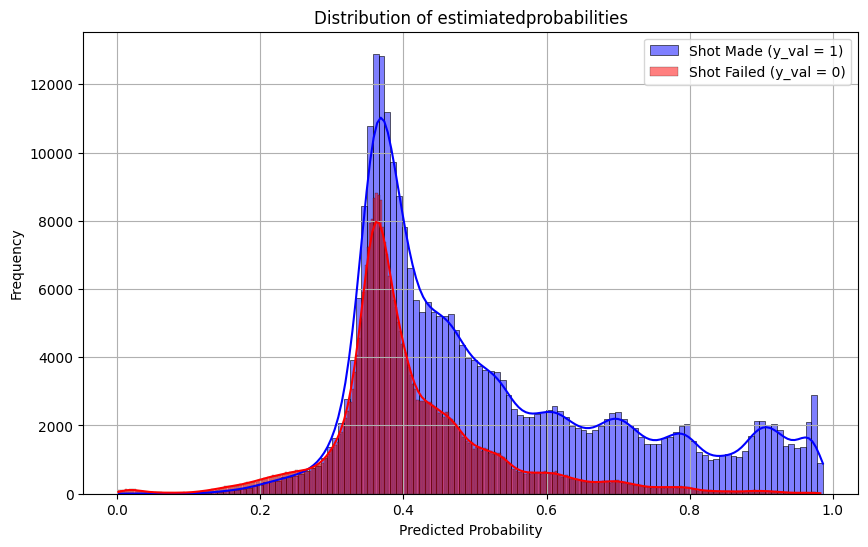

In [ ]:
XGB.fit(X_train, y_train)


y_pred = XGB.predict(X_val)
y_prob = XGB.predict_proba(X_val)[:, 1]

accuracy = accuracy_score(y_val.values, y_pred)
precision = precision_score(y_val, y_pred)
recall = recall_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")

plot_roc_curve(XGB, X_val, y_val)

classification_data = pd.DataFrame({"y_val": y_val.values, "y_prob": y_prob})

plt.figure(figsize=(10, 6))
sns.boxplot(
    x="y_val",
    y="y_prob",
    data=classification_data,
    palette="Set2",
)

# Let's see distribution of probabilities

shot_made = classification_data.loc[classification_data.y_val == 1]
shot_failed = classification_data.loc[classification_data.y_val == 0]

plt.figure(figsize=(10, 6))

sns.histplot(
    shot_made["y_prob"],
    label="Shot Made (y_val = 1)",
    kde=True,
    color="blue",
    alpha=0.5,
)
sns.histplot(
    shot_failed["y_prob"],
    label="Shot Failed (y_val = 0)",
    kde=True,
    color="red",
    alpha=0.5,
)

plt.title("Distribution of estimiatedprobabilities")
plt.xlabel("Predicted Probability")
plt.legend()
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

From the histogram, for LR it slightly shifted to the right, but it did not make a big change.

It seems like 'player stat' is meaningful, so how about
1. Dividing player shot success rate by 2pt, 3pt and
2. Adding interaction term for this?

In [ ]:
players = np.unique(df[["PLAYER_ID"]])
player_goal_stat = {}

for p in players:
    temp = df.loc[df["PLAYER_ID"] == p]["SHOT_MADE"]
    avg = round(sum(temp.values) / temp.shape[0], 2)
    player_goal_stat[p] = avg

df["PLAYER_AVG_SHOT_RATE"] = df["PLAYER_ID"].apply(lambda x: player_goal_stat[x])

df["TARGET"] = [1 if i == True else 0 for i in df.SHOT_MADE.values]

players = np.unique(df[["PLAYER_ID"]])
player_goal_stat = {}

for p in players:
    temp = df.loc[df["PLAYER_ID"] == p]["SHOT_MADE"]
    avg = round(sum(temp.values) / temp.shape[0], 2)
    player_goal_stat[p] = avg

player_2pt_stat = {}
for p in players:
    temp = df.loc[(df["PLAYER_ID"] == p) & (df["SHOT_TYPE"] == "2PT Field Goal")][
        "SHOT_MADE"
    ]
    if temp.shape[0] == 0:
        avg = 0
    else:
        avg = round(sum(temp.values) / temp.shape[0], 2)
    player_2pt_stat[p] = avg

player_3pt_stat = {}
for p in players:
    temp = df.loc[(df["PLAYER_ID"] == p) & (df["SHOT_TYPE"] == "3PT Field Goal")][
        "SHOT_MADE"
    ]

    if temp.shape[0] == 0:
        avg = 0
    else:
        avg = round(sum(temp.values) / temp.shape[0], 2)
    player_3pt_stat[p] = avg

In [ ]:
df["PLAYER_AVG_SHOT_RATE"] = df["PLAYER_ID"].apply(lambda x: player_goal_stat[x])
df["PLAYER_AVG_2PT_RATE"] = df["PLAYER_ID"].apply(lambda x: player_2pt_stat[x])
df["PLAYER_AVG_3PT_RATE"] = df["PLAYER_ID"].apply(lambda x: player_3pt_stat[x])
df["TARGET"] = [1 if i == True else 0 for i in df.SHOT_MADE.values]

numerical = [
    "PLAYER_AVG_SHOT_RATE",
    "PLAYER_AVG_3PT_RATE",
    "PLAYER_AVG_2PT_RATE",
    "LOC_X",
    "LOC_Y",
    "SHOT_DISTANCE",
    "QUARTER",
    "MINS_LEFT",
    "SECS_LEFT",
]
categorical = [
    "SEASON_2",
    # "ZONE_ABB",
    # "ZONE_NAME",
    "ACTION_TYPE",
    "SHOT_TYPE",
    "BASIC_ZONE",
    # "POSITION_GROUP",
    "POSITION",
    "IS_PLAYER_HOME",
    "ZONE_RANGE",
]

In [ ]:
scaler = StandardScaler()
encoder = OneHotEncoder(sparse_output=False)

# Scaling
numerical_scaled = scaler.fit_transform(df[numerical])
numerical_scaled = pd.DataFrame(numerical_scaled, columns=df[numerical].columns)


# ONE-HOT Encoding
categorical_encoded = encoder.fit_transform(df[categorical])
categorical_encoded = pd.DataFrame(
    categorical_encoded, columns=encoder.get_feature_names_out()
)

In [ ]:
X_transformed = pd.concat([numerical_scaled, categorical_encoded], axis=1)
y = df["TARGET"]

In [ ]:
X_transformed["interaction_term_3pt_distance"] = (
    X_transformed["SHOT_TYPE_3PT Field Goal"] * X_transformed["SHOT_DISTANCE"]
)

X_transformed["interaction_term_3pt_rate"] = (
    X_transformed["SHOT_TYPE_3PT Field Goal"] * X_transformed["PLAYER_AVG_3PT_RATE"]
)

X_transformed["interaction_term_2pt_rate"] = (
    X_transformed["SHOT_TYPE_2PT Field Goal"] * X_transformed["PLAYER_AVG_2PT_RATE"]
)

In [ ]:
X_transformed

,PLAYER_AVG_SHOT_RATE,PLAYER_AVG_3PT_RATE,PLAYER_AVG_2PT_RATE,LOC_X,LOC_Y,SHOT_DISTANCE,QUARTER,MINS_LEFT,SECS_LEFT,SEASON_2_2014-15,...,POSITION_nan,IS_PLAYER_HOME_False,ZONE_RANGE_16-24 ft.,ZONE_RANGE_24+ ft.,ZONE_RANGE_8-16 ft.,ZONE_RANGE_Back Court Shot,ZONE_RANGE_Less Than 8 ft.,interaction_term_3pt_distance,interaction_term_3pt_rate,interaction_term_2pt_rate
0,0.152199,0.460891,0.150606,2.494160,0.100408,1.039776,-1.305991,1.633347,-0.506519,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.039776,0.460891,0.000000
1,-0.030534,0.327509,-0.043431,-0.051184,2.263420,1.231829,-1.305991,1.344086,1.329183,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.231829,0.327509,-0.000000
2,0.334933,0.727656,0.344644,-0.147437,-0.799872,-1.168833,-1.305991,1.344086,0.583429,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,-0.000000,0.000000,0.344644
3,-0.030534,0.327509,-0.043431,-0.019100,-0.566033,-1.072807,-1.305991,1.344086,0.124503,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,-0.000000,0.000000,-0.043431
4,-0.030534,-0.072638,0.538681,0.184099,-0.577725,-1.072807,-1.305991,1.344086,-1.367004,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,-0.000000,-0.000000,0.538681
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2086274,-0.396001,0.594274,-0.237469,1.264267,2.076349,1.327855,1.337851,-1.548527,1.099720,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.327855,0.594274,-0.000000
2086275,2.893200,-4.474254,2.090981,0.162710,0.252404,-0.400622,1.337851,-1.548527,0.927623,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,-0.000000,-0.000000,2.090981
2086276,2.893200,-4.474254,2.090981,0.055763,-0.273734,-0.880754,1.337851,-1.548527,0.870257,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,-0.000000,-0.000000,2.090981
2086277,-0.030534,0.060744,-0.237469,-0.190216,2.625870,1.519908,1.337851,-1.548527,0.468697,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.519908,0.060744,-0.000000


Accuracy: 0.626761508522346
Precision: 0.650807348279925
Recall: 0.40832751996501565
F1-Score: 0.5018105974331742
Logistic Regression:


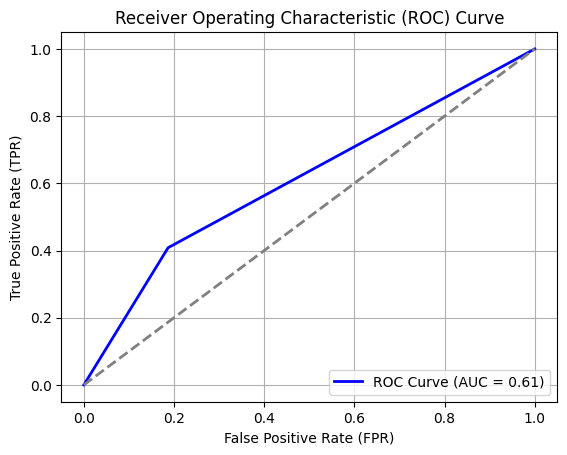

<ipython-input-56-3433f18619fb>:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


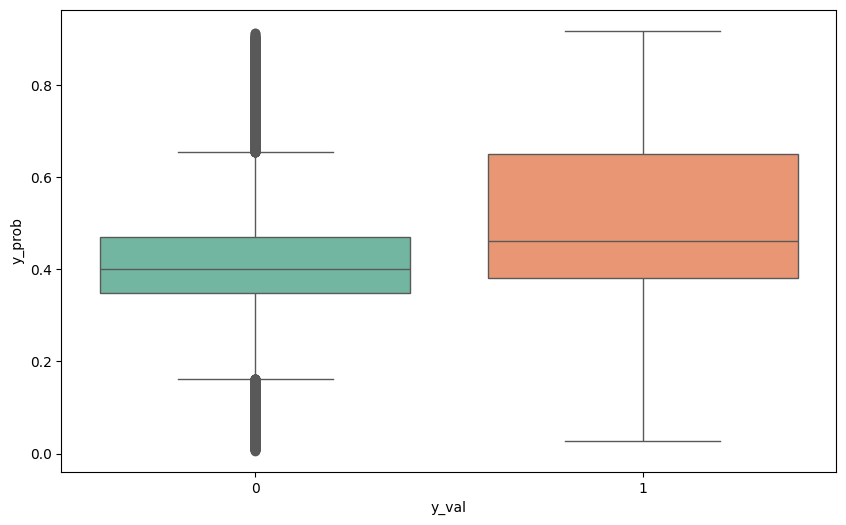

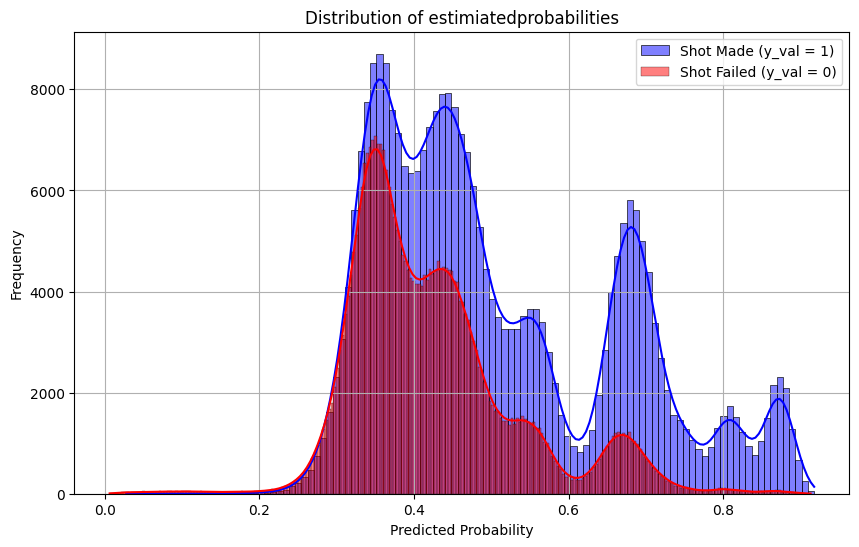

In [ ]:
logistic_regression = LogisticRegression(
    penalty="l1", C=0.001, solver="liblinear"
)  # Native Parameters


X_train, X_val, y_train, y_val = train_test_split(
    X_transformed, y, test_size=0.3, random_state=20
)

logistic_regression.fit(X_train, y_train)
y_pred = logistic_regression.predict(X_val)
y_prob = logistic_regression.predict_proba(X_val)[:, 1]

accuracy = accuracy_score(y_val.values, y_pred)
precision = precision_score(y_val, y_pred)
recall = recall_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")

print("Logistic Regression:")
plot_roc_curve(logistic_regression, X_val, y_val)

classification_data = pd.DataFrame({"y_val": y_val.values, "y_prob": y_prob})

plt.figure(figsize=(10, 6))
sns.boxplot(
    x="y_val",
    y="y_prob",
    data=classification_data,
    palette="Set2",
)

# Let's see distribution of probabilities

shot_made = classification_data.loc[classification_data.y_val == 1]
shot_failed = classification_data.loc[classification_data.y_val == 0]

plt.figure(figsize=(10, 6))

sns.histplot(
    shot_made["y_prob"],
    label="Shot Made (y_val = 1)",
    kde=True,
    color="blue",
    alpha=0.5,
)
sns.histplot(
    shot_failed["y_prob"],
    label="Shot Failed (y_val = 0)",
    kde=True,
    color="red",
    alpha=0.5,
)

plt.title("Distribution of estimiatedprobabilities")
plt.xlabel("Predicted Probability")
plt.legend()
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

Accuracy: 0.641566168810834
Precision: 0.6814192513551485
Recall: 0.41578945541753864
F1-Score: 0.5164504030693624


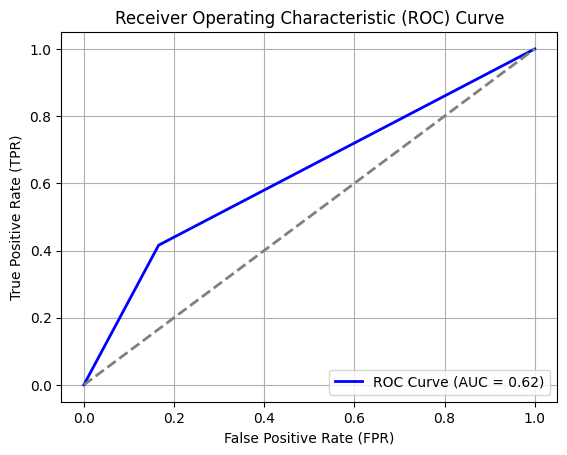

<ipython-input-57-bb3156a5e058>:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


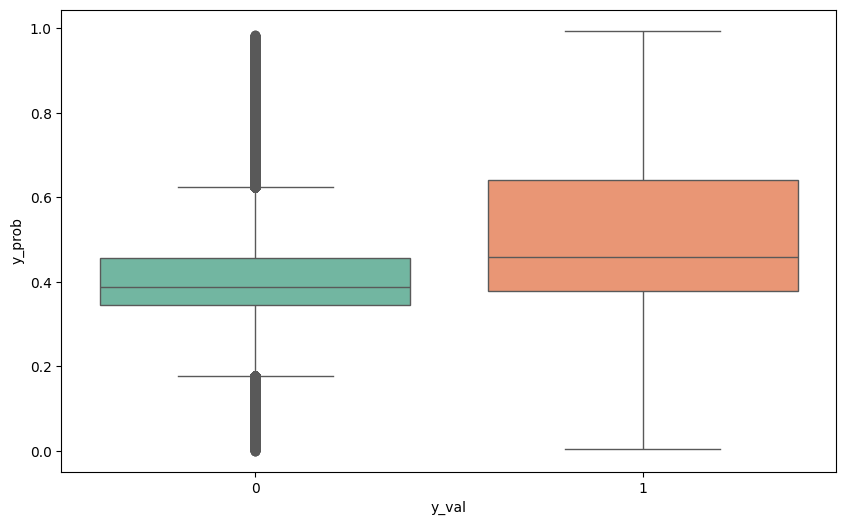

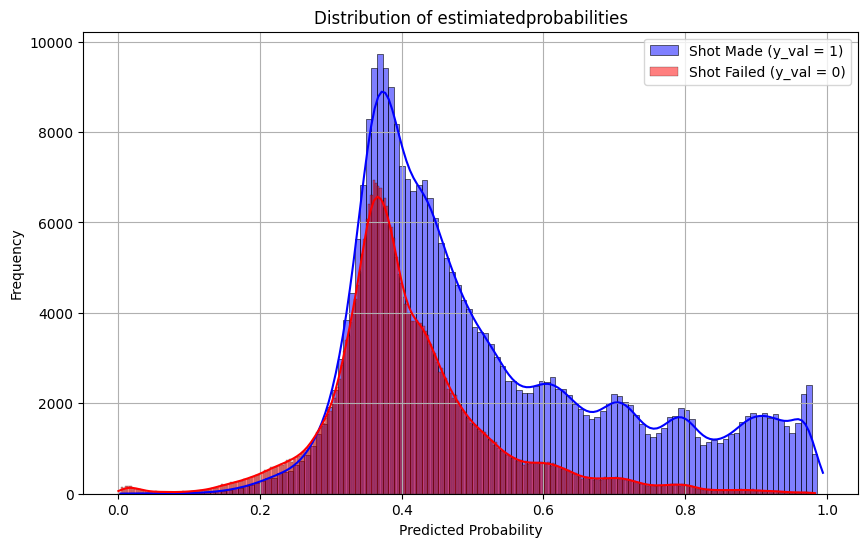

In [ ]:
XGB = XGBClassifier(objective="binary:logistic")
XGB.fit(X_train, y_train)


y_pred = XGB.predict(X_val)
y_prob = XGB.predict_proba(X_val)[:, 1]

accuracy = accuracy_score(y_val.values, y_pred)
precision = precision_score(y_val, y_pred)
recall = recall_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")

plot_roc_curve(XGB, X_val, y_val)

classification_data = pd.DataFrame({"y_val": y_val.values, "y_prob": y_prob})

plt.figure(figsize=(10, 6))
sns.boxplot(
    x="y_val",
    y="y_prob",
    data=classification_data,
    palette="Set2",
)

# Let's see distribution of probabilities

shot_made = classification_data.loc[classification_data.y_val == 1]
shot_failed = classification_data.loc[classification_data.y_val == 0]

plt.figure(figsize=(10, 6))

sns.histplot(
    shot_made["y_prob"],
    label="Shot Made (y_val = 1)",
    kde=True,
    color="blue",
    alpha=0.5,
)
sns.histplot(
    shot_failed["y_prob"],
    label="Shot Failed (y_val = 0)",
    kde=True,
    color="red",
    alpha=0.5,
)

plt.title("Distribution of estimiatedprobabilities")
plt.xlabel("Predicted Probability")
plt.legend()
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

Deep Learning   

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD
from keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import GridSearchCV
from keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import AUC
from tensorflow.keras.metrics import Precision, Recall

parameters = {'layers': [[32, 16, 8]],
 'dropout_rates': [0.2],
 'learning_rate': [0.001],
 'batch_size': [32]}

epochs = 30

def build_final_model(parameters, X_train, X_val, y_train, y_val):
    best_model = None
    best_val_auc = float('-inf')  # Track the best AUC
    best_history = None
    best_params = None

    for layers in parameters["layers"]:
        for dropout_rate in parameters["dropout_rates"]:
            for learning_rate in parameters["learning_rate"]:
                # Build the model
                model = Sequential()
                model.add(
                    Dense(units=layers[0], input_dim=X_train.shape[1], activation="relu", kernel_regularizer=l2(0.01))
                )
                print(
                    f"Working on layer: {layers}, dropout rate: {dropout_rate}, learning rate: {learning_rate}, batch size: 32, epochs: {epochs}"
                )

                for hidden in layers[1:]:
                    model.add(Dense(units=hidden, activation="relu", kernel_regularizer=l2(0.01)))
                    model.add(Dropout(dropout_rate))

                model.add(Dense(units=1, activation="sigmoid"))

                optimizer = Adam(learning_rate=learning_rate)
                model.compile(optimizer=optimizer, loss="binary_crossentropy",
                              metrics=["accuracy", AUC(name='auc'), Precision(name='precision'), Recall(name='recall')])

                # Train the model
                history = model.fit(
                    X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=epochs,
                    batch_size=32,
                    verbose=0,
                    callbacks=[early_stopping]
                )

                # Evaluate the model
                eval_metrics = model.evaluate(X_val, y_val, verbose=0)
                val_auc = eval_metrics[2]  # AUC is the third metric in your setup

                # Track the best model based on AUC
                if val_auc > best_val_auc:
                    best_val_auc = val_auc
                    best_model = model
                    best_history = history
                    best_params = {"layers": layers, "dropout_rate": dropout_rate, "learning_rate": learning_rate, "batch_size": 32}

    print(f"Best Validation AUC: {best_val_auc}")
    print(f"Best Parameters: {best_params}")
    return best_model, best_history, best_params


In [ ]:
best_model_output = build_final_model(parameters, X_train, X_val, y_train, y_val)


best_model = best_model_output[0]
best_params = best_model_output[-1]

!mkdir -p saved_model
tf.saved_model.save(best_model, 'saved_model/my_model_V2_AUC')
saved_model = tf.saved_model.load('saved_model/my_model_V2_AUC')

Working on layer: [32, 16, 8], dropout rate: 0.2, learning rate: 0.001, batch size: 32, epochs: 30
Best Validation AUC: 0.6480037569999695
Best Parameters: {'layers': [32, 16, 8], 'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 32}


{'layers': [32, 16, 8], 'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 32}
19559/19559 ━━━━━━━━━━━━━━━━━━━━ 21s 1ms/step
19559/19559 ━━━━━━━━━━━━━━━━━━━━ 20s 1ms/step
Accuracy: 0.630185465677346
Precision: 0.659414418976246
Recall: 0.406772660856769
F1-Score: 0.5031607733537683
19559/19559 ━━━━━━━━━━━━━━━━━━━━ 20s 1ms/step


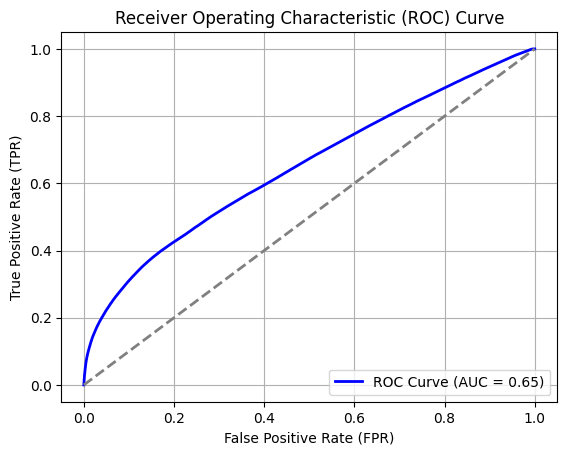

<ipython-input-71-81e8717f601d>:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


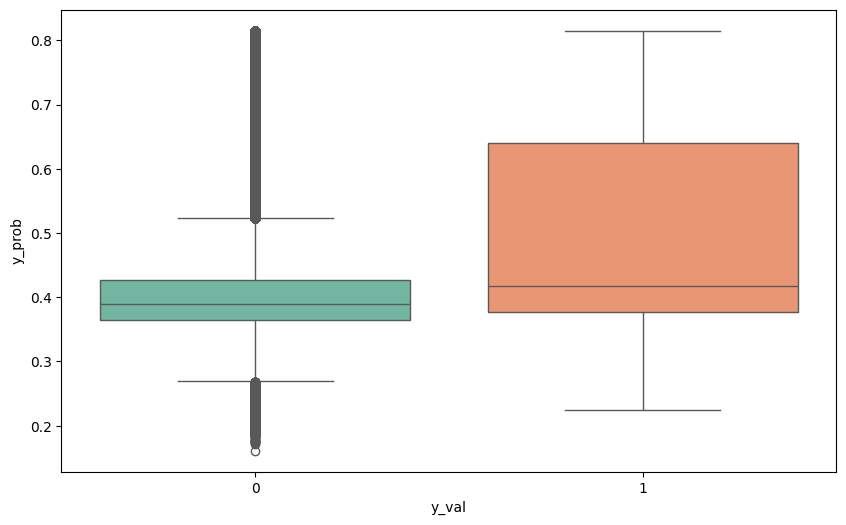

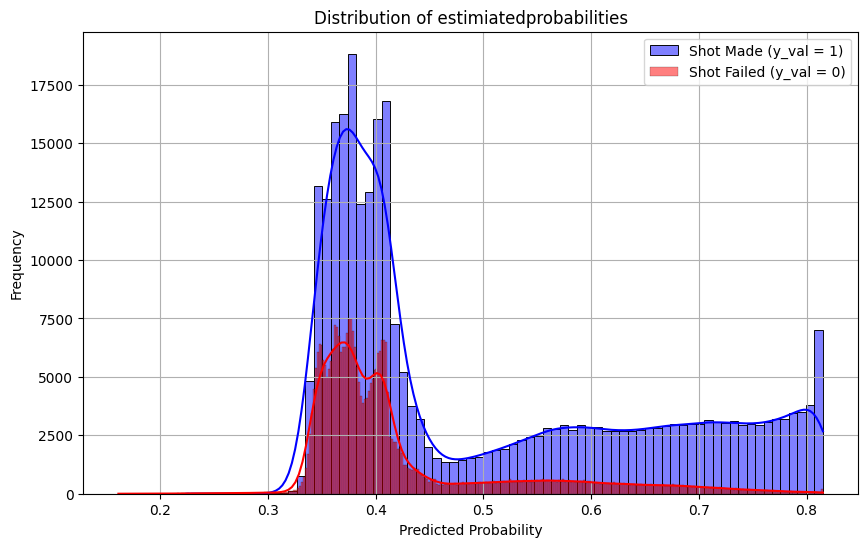

In [ ]:
print(best_params)

def get_prediction_classes(neural_net, threshold, X):

    y_prob = neural_net.predict(X)
    threshold = threshold
    y_pred = (y_prob > threshold).astype(
        "int32"
    )  # Convert probabilities to class labels
    return (y_prob, y_pred)


y_pred = get_prediction_classes(best_model, 0.5, X_val)[1]
y_prob = get_prediction_classes(best_model, 0.5, X_val)[0]

accuracy = accuracy_score(y_val.values, y_pred)
precision = precision_score(y_val, y_pred)
recall = recall_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")

plot_roc_curve(best_model, X_val, y_val)

classification_data = pd.DataFrame({"y_val": y_val.values, "y_prob": y_prob[:, 0]})

plt.figure(figsize=(10, 6))
sns.boxplot(
    x="y_val",
    y="y_prob",
    data=classification_data,
    palette="Set2",
)

# Let's see distribution of probabilities

shot_made = classification_data.loc[classification_data.y_val == 1]
shot_failed = classification_data.loc[classification_data.y_val == 0]

plt.figure(figsize=(10, 6))

sns.histplot(
    shot_made["y_prob"],
    label="Shot Made (y_val = 1)",
    kde=True,
    color="blue",
    alpha=0.5,
)
sns.histplot(
    shot_failed["y_prob"],
    label="Shot Failed (y_val = 0)",
    kde=True,
    color="red",
    alpha=0.5,
)

plt.title("Distribution of estimiatedprobabilities")
plt.xlabel("Predicted Probability")
plt.legend()
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

# Try more complex paters to improve sumble patterns

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD
from keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import GridSearchCV
from keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import AUC
from tensorflow.keras.metrics import Precision, Recall

parameters = {
    "layers": [
        [64, 32, 16],  # Increased complexity
        [32, 16],      # A slightly simpler alternative
    ],
    "dropout_rates": [0.2, 0.3],  # Explore slightly higher dropout
    "learning_rate": [0.001, 0.0005],  # Add a smaller learning rate for fine-tuning
    "batch_size": [32, 64]  # Include a larger batch size for stability
}
epochs = 50

def build_final_model(parameters, X_train, X_val, y_train, y_val):
    best_model = None
    best_val_auc = float('-inf')  # Track the best AUC
    best_history = None
    best_params = None

    for layers in parameters["layers"]:
        for dropout_rate in parameters["dropout_rates"]:
            for learning_rate in parameters["learning_rate"]:
                for batch_size in parameters["batch_size"]:
                  # Build the model
                  model = Sequential()
                  model.add(
                      Dense(units=layers[0], input_dim=X_train.shape[1], activation="relu", kernel_regularizer=l2(0.01))
                  )
                  print(
                      f"Working on layer: {layers}, dropout rate: {dropout_rate}, learning rate: {learning_rate}, batch size: 32, epochs: {epochs}"
                  )

                  for hidden in layers[1:]:
                      model.add(Dense(units=hidden, activation="relu", kernel_regularizer=l2(0.01)))
                      model.add(Dropout(dropout_rate))

                  model.add(Dense(units=1, activation="sigmoid"))

                  optimizer = Adam(learning_rate=learning_rate)
                  model.compile(optimizer=optimizer, loss="binary_crossentropy",
                                metrics=["accuracy", AUC(name='auc'), Precision(name='precision'), Recall(name='recall')])

                  # Train the model
                  history = model.fit(
                      X_train, y_train,
                      validation_data=(X_val, y_val),
                      epochs=epochs,
                      batch_size=32,
                      verbose=0,
                      callbacks=[early_stopping]
                  )

                  # Evaluate the model
                  eval_metrics = model.evaluate(X_val, y_val, verbose=0)
                  val_auc = eval_metrics[2]  # AUC is the third metric in your setup

                  # Track the best model based on AUC
                  if val_auc > best_val_auc:
                      best_val_auc = val_auc
                      best_model = model
                      best_history = history
                      best_params = {"layers": layers, "dropout_rate": dropout_rate, "learning_rate": learning_rate, "batch_size": 32}

    print(f"Best Validation AUC: {best_val_auc}")
    print(f"Best Parameters: {best_params}")
    return best_model, best_history, best_params


In [ ]:
best_model_output = build_final_model(parameters, X_train, X_val, y_train, y_val)


best_model = best_model_output[0]
best_params = best_model_output[-1]

!mkdir -p saved_model
tf.saved_model.save(best_model, 'saved_model/my_model_V3_AUC')
saved_model = tf.saved_model.load('saved_model/my_model_V3_AUC')

print(best_params)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Working on layer: [64, 32, 16], dropout rate: 0.2, learning rate: 0.001, batch size: 32, epochs: 50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Working on layer: [64, 32, 16], dropout rate: 0.2, learning rate: 0.001, batch size: 32, epochs: 50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Working on layer: [64, 32, 16], dropout rate: 0.2, learning rate: 0.0005, batch size: 32, epochs: 50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Working on layer: [64, 32, 16], dropout rate: 0.2, learning rate: 0.0005, batch size: 32, epochs: 50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Working on layer: [64, 32, 16], dropout rate: 0.3, learning rate: 0.001, batch size: 32, epochs: 50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Working on layer: [64, 32, 16], dropout rate: 0.3, learning rate: 0.001, batch size: 32, epochs: 50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Working on layer: [64, 32, 16], dropout rate: 0.3, learning rate: 0.0005, batch size: 32, epochs: 50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Working on layer: [64, 32, 16], dropout rate: 0.3, learning rate: 0.0005, batch size: 32, epochs: 50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Working on layer: [32, 16], dropout rate: 0.2, learning rate: 0.001, batch size: 32, epochs: 50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Working on layer: [32, 16], dropout rate: 0.2, learning rate: 0.001, batch size: 32, epochs: 50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Working on layer: [32, 16], dropout rate: 0.2, learning rate: 0.0005, batch size: 32, epochs: 50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Working on layer: [32, 16], dropout rate: 0.2, learning rate: 0.0005, batch size: 32, epochs: 50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Working on layer: [32, 16], dropout rate: 0.3, learning rate: 0.001, batch size: 32, epochs: 50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Working on layer: [32, 16], dropout rate: 0.3, learning rate: 0.001, batch size: 32, epochs: 50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Working on layer: [32, 16], dropout rate: 0.3, learning rate: 0.0005, batch size: 32, epochs: 50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Working on layer: [32, 16], dropout rate: 0.3, learning rate: 0.0005, batch size: 32, epochs: 50
Best Validation AUC: 0.6630256175994873
Best Parameters: {'layers': [32, 16], 'dropout_rate': 0.2, 'learning_rate': 0.0005, 'batch_size': 32}
{'layers': [32, 16], 'dropout_rate': 0.2, 'learning_rate': 0.0005, 'batch_size': 32}


19559/19559 ━━━━━━━━━━━━━━━━━━━━ 20s 1ms/step
19559/19559 ━━━━━━━━━━━━━━━━━━━━ 20s 996us/step
Accuracy: 0.6348860172172479
Precision: 0.6983456224878217
Recall: 0.36420839276851685
F1-Score: 0.478739589915077
19559/19559 ━━━━━━━━━━━━━━━━━━━━ 20s 1ms/step


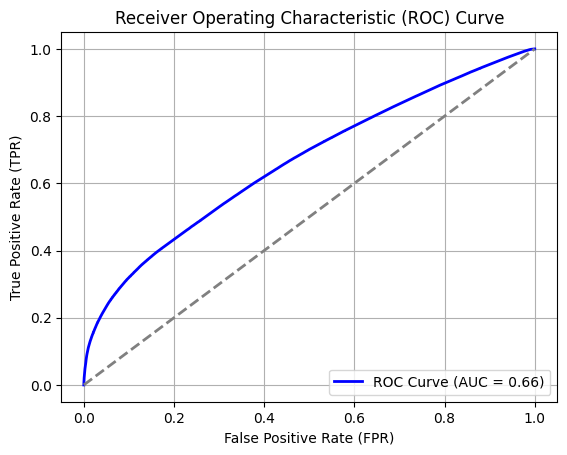

<ipython-input-80-12ea622b3651>:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


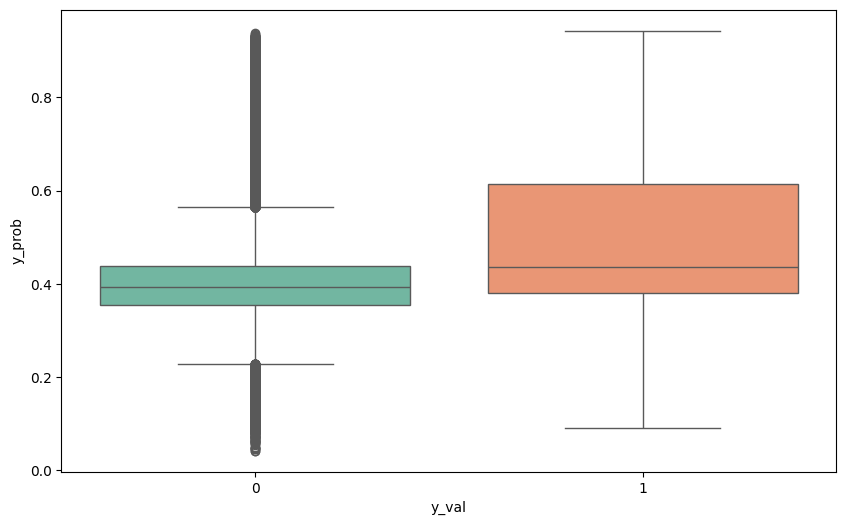

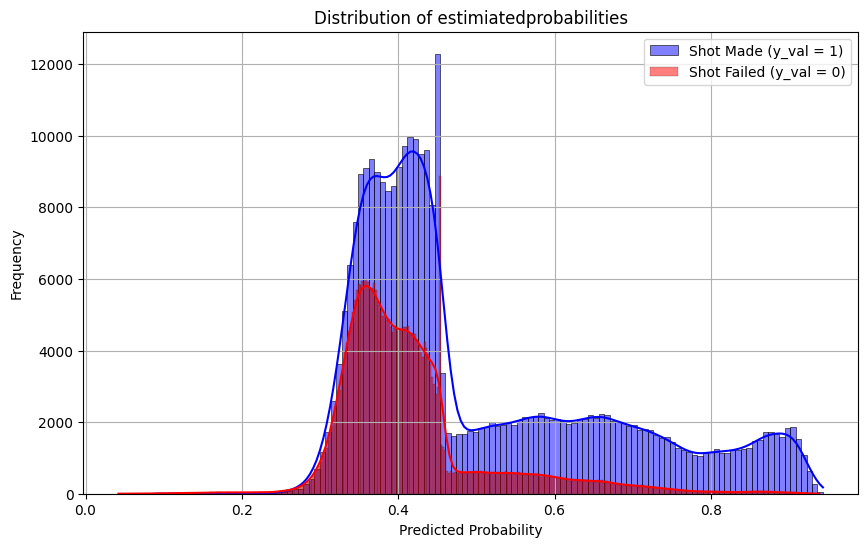

In [ ]:

def get_prediction_classes(neural_net, threshold, X):

    y_prob = neural_net.predict(X)
    threshold = threshold
    y_pred = (y_prob > threshold).astype(
        "int32"
    )  # Convert probabilities to class labels
    return (y_prob, y_pred)


y_pred = get_prediction_classes(best_model, 0.5, X_val)[1]
y_prob = get_prediction_classes(best_model, 0.5, X_val)[0]

accuracy = accuracy_score(y_val.values, y_pred)
precision = precision_score(y_val, y_pred)
recall = recall_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")

plot_roc_curve(best_model, X_val, y_val)

classification_data = pd.DataFrame({"y_val": y_val.values, "y_prob": y_prob[:, 0]})

plt.figure(figsize=(10, 6))
sns.boxplot(
    x="y_val",
    y="y_prob",
    data=classification_data,
    palette="Set2",
)

# Let's see distribution of probabilities

shot_made = classification_data.loc[classification_data.y_val == 1]
shot_failed = classification_data.loc[classification_data.y_val == 0]

plt.figure(figsize=(10, 6))

sns.histplot(
    shot_made["y_prob"],
    label="Shot Made (y_val = 1)",
    kde=True,
    color="blue",
    alpha=0.5,
)
sns.histplot(
    shot_failed["y_prob"],
    label="Shot Failed (y_val = 0)",
    kde=True,
    color="red",
    alpha=0.5,
)

plt.title("Distribution of estimiatedprobabilities")
plt.xlabel("Predicted Probability")
plt.legend()
plt.ylabel("Frequency")
plt.grid(True)
plt.show()